<a href="https://colab.research.google.com/github/TieuDiem/Resize-Image-Interpolation/blob/main/Resize_Image_Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import math
import time

In [42]:
def process_time(func):
    def wrap_func(*args, **kwargs):
        t1 = time.time()
        result = func(*args, **kwargs)
        t2 = time.time()
        print(f'Function {func.__name__!r} executed in {(t2-t1)*1000:.4f}ms')
        return result
    return wrap_func

In [39]:
path_image = '/content/134206.jpg'
img =cv2.imread(path_image)
img.shape

(375, 500, 3)

In [65]:
dim =(int(img.shape[0]*0.7) ,int(img.shape[1]*0.7))

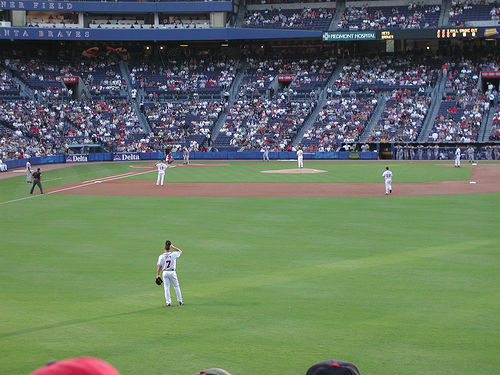

In [14]:
cv2_imshow(img)

In [50]:
print(f'math.floor(4.8): {math.floor(4.8)}')
print(f'math.floor(4.1): {math.floor(4.1)}')
print(f'----------------------------------')
print(f'math.ceil(4.1): {math.ceil(4.1)}')
print(f'math.ceil(4.8): {math.ceil(4.8)}')

math.floor(4.8): 4
math.floor(4.1): 4
----------------------------------
math.ceil(4.1): 5
math.ceil(4.8): 5


# Nearest Neightbor Interpolation

In [40]:
@process_time
def resize_nearest_neightbor(image, new_height, new_width):
  
  if len (image.shape)==3:
    old_h, old_w, channel = image.shape 
    new_image = np.zeros((new_height, new_width, channel), dtype=np.uint8)
  else:
    old_h, old_w =image.shape 
    new_image = np.zeros((new_height, new_width), dtype=np.uint8)
  
  w_scale_factor = old_w / new_width
  h_scale_factor = old_h / new_height

  for y_i_new in range(new_height):
      y_i_new_scaled = math.floor(y_i_new * h_scale_factor)
      for x_i_new in range(new_width):
          x_i_new_scaled = math.floor(x_i_new * w_scale_factor)
          new_image[y_i_new, x_i_new] = image[y_i_new_scaled, x_i_new_scaled]
  return new_image

Function 'resize_nearest_neightbor' executed in 85.7289ms


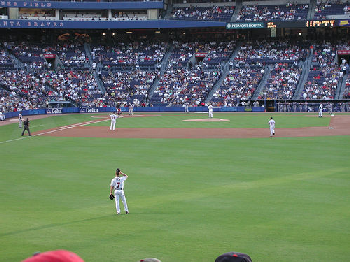

In [66]:
new_image_nearest = resize_nearest_neightbor(image = img,
                                     new_height = dim[0],
                                     new_width  = dim[1])
cv2_imshow(new_image_nearest)

In [67]:
new_image_nearest_gray = resize_nearest_neightbor(image =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),
                                          new_height = dim[0],
                                          new_width  = dim[1])

Function 'resize_nearest_neightbor' executed in 54.1217ms


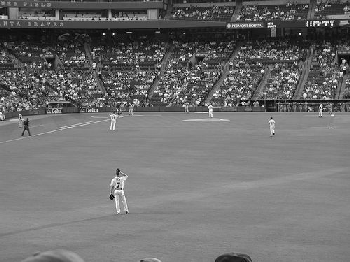

In [62]:
cv2_imshow(new_image_nearest_gray)

## Compare with OpenCV

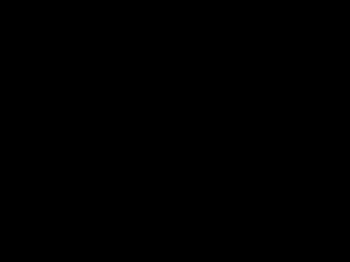

In [72]:
img_resize_nearest =cv2.resize(img,(dim[1],dim[0]),interpolation=cv2.INTER_NEAREST)
result_color =  new_image_nearest -img_resize_nearest
cv2_imshow(result_color)

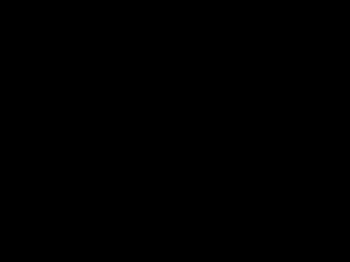

In [73]:
img_gray_resize_nearest =cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),(dim[1],dim[0]),interpolation=cv2.INTER_NEAREST)
result_gray =  new_image_nearest_gray -img_gray_resize_nearest
cv2_imshow(result_gray)

# Bilinear Interpolation

In [75]:
@process_time
def resize_bilinear_interpolation(image, new_height, new_width):

  # Create new mask
  if len(image.shape) ==3:
    old_h, old_w,chanels = image.shape
    new_image = np.zeros((new_height, new_width,chanels))
  else:
    old_h, old_w = image.shape
    new_image = np.zeros((new_height, new_width))

  # Calculate scale factor
  w_scale_factor = old_w / new_width
  h_scale_factor = old_h / new_height

  # Fill new mask -> new image
  for yi_new in range(new_height):
    yi_new_scaled = math.floor(yi_new * h_scale_factor)
    for xi_new in range(new_width):
        xi_new_scaled = math.floor(xi_new * w_scale_factor)
        x1 = math.floor(xi_new_scaled)
        x2 = min(old_w - 1, math.ceil(xi_new_scaled))
        y2 = math.floor(yi_new_scaled)
        y1 = min(old_h - 1, math.ceil(yi_new_scaled))
        f_p = 0
        if (x2 == x1) and (y2 == y1):
            f_p = image[yi_new_scaled, xi_new_scaled]
        elif x2 == x1:
          f_r1 = image[y1, xi_new_scaled]
          f_r2 = image[y2, xi_new_scaled]
          f_p = ((y2 - yi_new) / (y2 - y1)) * f_r1 + \
                ((yi_new - y1) / (y2 - y1)) * f_r2
        elif y2 == y1:
          f_rx1 = image[yi_new_scaled, x1]
          f_rx2 = image[yi_new_scaled, x2]
          f_p = ((x2 - xi_new) / (x2 - x1)) * f_rx1 + \
                ((xi_new - x1) / (x2 - x1)) * f_rx2
        else:
          f_q11 = image[y1, x1]
          f_q12 = image[y2, x1]
          f_q21 = image[x2, y1]
          f_q22 = image[x2, y2]
          f_r1 = ((x2 - xi_new) / (x2 - x1)) * f_q11 + \
                  ((xi_new - x1) / (x2 - x1)) * f_q21
          f_r2 = ((x2 - xi_new) / (x2 - x1)) * f_q12 + \
                  ((xi_new - x1) / (x2 - x1)) * f_q22
          f_p  = ((y2 - yi_new) / (x2 - x1)) * f_r1 + \
                  ((yi_new - y1) / (y2 - y1)) * f_r2
        new_image[yi_new, xi_new] = f_p
  return new_image  

Function 'resize_bilinear_interpolation' executed in 204.4003ms


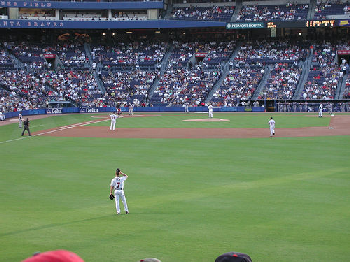

In [81]:
new_img_bilinear = resize_bilinear_interpolation(img,
                                                  new_height = int(img.shape[0]*0.7),
                                                  new_width  = int(img.shape[1]*0.7))
cv2_imshow(new_img_bilinear)

Function 'resize_bilinear_interpolation' executed in 163.1444ms


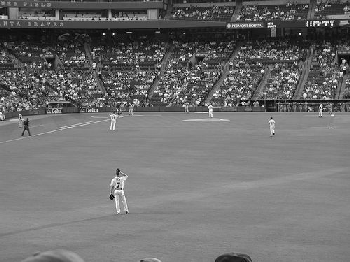

In [80]:
new_img_gray_bilinear = resize_bilinear_interpolation(image =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),
                                                  new_height = int(img.shape[0]*0.7),
                                                  new_width  = int(img.shape[1]*0.7))
cv2_imshow(new_img_gray_bilinear)

## Compare with OpenCV

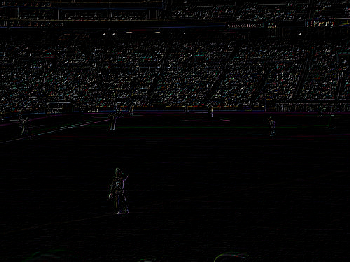

In [82]:
img_resize_linear =cv2.resize(img,(dim[1],dim[0]),interpolation=cv2.INTER_LINEAR)
result_color = new_img_bilinear - img_resize_linear
cv2_imshow(result_color)

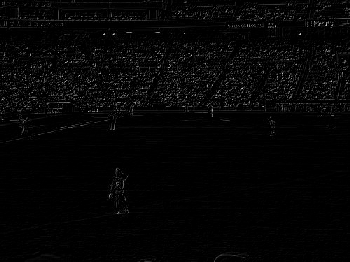

In [83]:
img_gray_resize_linear =cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),(dim[1],dim[0]),interpolation=cv2.INTER_LINEAR)
result_gray =  new_img_gray_bilinear - img_gray_resize_linear
cv2_imshow(result_gray)